# Target Encoder with Shap

This very short and simple notebook simplified the code of the last one. The idea is to use a new imputer and transformation for categorical variables(yes it do both!). This is the target encoder. And the way it handles the categorical variables is by creating a numerical value that has some corrolation/relation with the y.
This kind of behaviour is very appealing because it allow us to use shap easily to understand which variables are important.

In [6]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# these are used after we fit our model to evaluate which variables
# are more important and how they affect the model predictions
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# new libraries not use yet
import shap

# new library, we haven't used this one before in this repo
from sklearn.preprocessing import TargetEncoder

In [3]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

In [4]:
def cleaning_data(X,delete_over=10,col_to_change_to_null=0.1):
    
    categorical_variables = [col for col in  X.columns if str(X[col].dtypes)=='object']
    #numerical_variables = [col for col in X.columns if str(X[col].dtypes)!='object']
    cardinalidad = {}
    for col in categorical_variables:
        cardinalidad[col] = len(list(X[col].unique()))
    # For now we delete categories with more values than..
    delete_over = delete_over
    columns_to_delete = [col for col in categorical_variables if len(list(X[col].unique()))>delete_over ]
    X.drop(columns=columns_to_delete,inplace = True, axis=1)
    
    # We are going to change columns with too many null.
    # We are not gonna delete them, will give them the chance to be important.
    # that means that having or not having the value is what is really important.
    col_to_change_to_null = col_to_change_to_null
    columnas_modificar_por_1 = [col for col in X.columns if X[col].isnull().sum()>int(X.shape[0] * col_to_change_to_null) ]

    for col in columnas_modificar_por_1:
        X[col +str('_is_null')] = 0
        X.loc[(X[col].isnull()),col +str('_is_null')] = 1

    new_columns_null = [str(f"{col}_is_null") for col in columnas_modificar_por_1 ]    
    X.drop(columns=columnas_modificar_por_1, axis=1,inplace=True)
    
    return X

In [5]:
X = cleaning_data(X)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0)  

In [13]:
def transforming_modeling_scoring(X,y, n_estimators=369,n_jobs=-1):
      
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    #categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]

    numerical_transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=3))
      ]
        )

    target_transformer =  Pipeline(steps=[
        ('encoder', TargetEncoder(smooth="auto",target_type='continuous'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", target_transformer, categorical_col)])

    # Define model
    # we could put this outside in the function parameter to test differents models
    model = RandomForestRegressor(n_estimators=n_estimators,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    my_model = pipe.fit(X,y)
    new_X = pipe['preprocessor'].fit_transform(X,y)
    df = pd.DataFrame(new_X, columns=numerical_col+categorical_col)

    return my_model,df

In [14]:
my_model,X = transforming_modeling_scoring(X,y, n_estimators=369)


In [16]:
X.head() 

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,20.0,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,1774.0,...,188388.873314,214330.612097,185606.384181,202888.720904,143895.174638,188143.524432,189620.325349,188283.082665,279256.857740,277007.042906
1,20.0,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,894.0,...,188531.875197,140763.104543,184769.601910,135251.705031,143241.738707,188582.259057,189062.901428,187968.448488,174696.552004,176115.546638
2,30.0,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,163.0,...,184344.631958,138691.159119,180635.377468,133989.433716,140502.869903,184249.244040,184657.334913,183352.137171,170155.205414,172381.554088
3,20.0,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,350.0,...,188388.873314,214330.612097,185606.384181,202888.720904,203750.669127,188143.524432,189620.325349,188283.082665,174158.605594,175885.444320
4,20.0,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,1541.0,...,188531.875197,212906.223528,184769.601910,205011.445921,202331.034813,188582.259057,189062.901428,187968.448488,174696.552004,176115.546638


## Analyzing some examples using shap

In [21]:
# Get the final estimator from the pipeline
model = my_model['model']
index_to_show = 150
X_value = X[X.index==index_to_show]
# Initialize the TreeExplainer with the model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_value)
shap_obj = explainer(X_value)

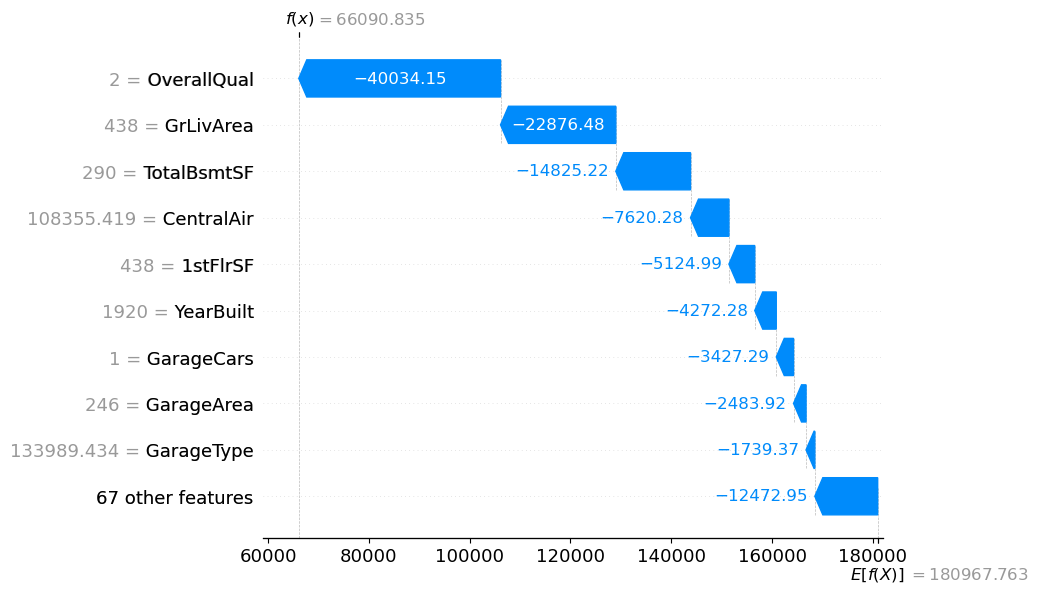

In [22]:
shap.plots.waterfall(shap_obj[0])

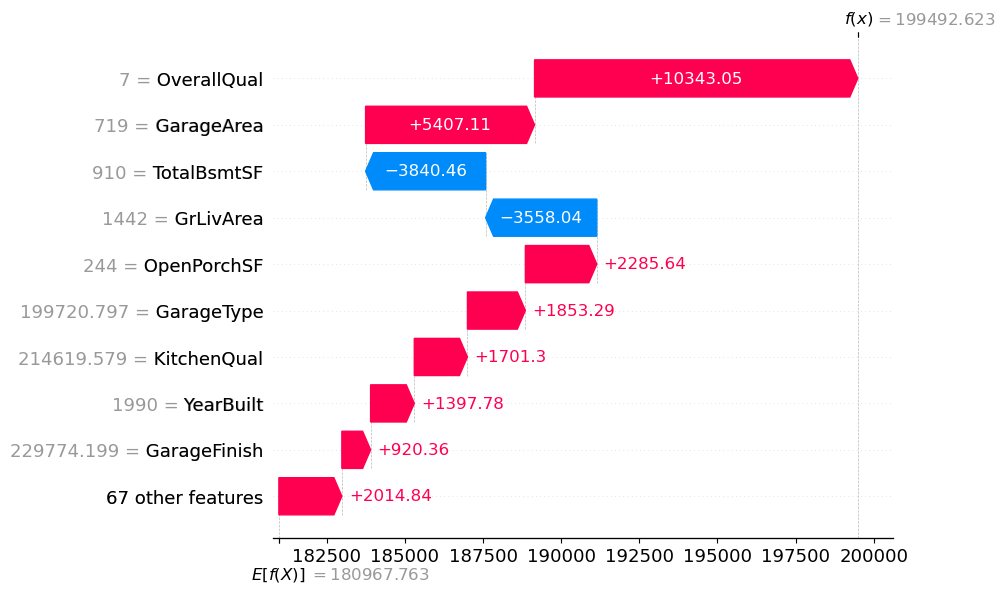

In [25]:
model = my_model['model']
index_to_show = 1100
X_value = X[X.index==index_to_show]
# Initialize the TreeExplainer with the model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_value)
shap_obj = explainer(X_value)
shap.plots.waterfall(shap_obj[0])

Notice that now it way easier to see what the model is using to predict. Before, I mean in the previous notebook because we use one-hot-encoding we got in the output of the shap, some very weird names corresponding of the sparce categorical column creating by the pipeline. Now it is way easier to interpret the results!!